# Adversarial　Example - JSMA編-
Adversarial Exampleによる攻撃の一つとして、Jacobian Saliency Map Attackがある。これについて実装していこう。
今回の手法については、以下のような特徴がある。
- ホワイトボックス攻撃
- FGSMよりもノイズの少ない攻撃が可能である。

まずはライブラリのインポート

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt


ディレクトリの作成。事前に学習したモデルを取り込む。
``` bash
wget 'https://drive.google.com/uc?export=download&id=1KVOHbHnjCd1L-ookcd7CxDqb7rb8-DSx' -O './data/lenet_mnist_model.pth'
```

In [3]:
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

# MNIST分類モデルの定義
.pthファイルはモデルの重みを与えている。そのため、モデルの構造を定義する必要がある。

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## データセットとデータローダーの定義

MNISTデータセットからデータローダーを作成する。
ここで、transforms.ToTensor()は自動で0~1の範囲に変換してくれる。

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)


device = torch.device("cuda" if (use_cuda and torch.cuda.is_available())else "cpu")

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model,map_location='cpu'))

model.eval()# 推論を有効に

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## 攻撃するためのモデルの定義

JSMAでは以下のように摂動を加える。
画像xに対して、tと誤認識させたいときのxのi番目のピクセルへの摂動は$S(x,t)[i]$は

$$
S(x,t)[i] = \begin{cases}
0 & \text{if } \frac{\partial F_t}{\partial x_i}(x)　<0  \text{OR} \sum_{j\neq t} \frac{\partial F_j}{\partial x_i}(x) >0 \\
\frac{\partial F_t}{\partial x_i}(x) \mid\mid \sum_{j\neq t} \frac{\partial F_j}{\partial x_i}(x) \mid\mid & \text{otherwise}
\end{cases}
$$

まずは入力に対する出力の勾配を求める必要がある。このとき、それぞれの尤度に対して勾配を求める必要があることに注意が必要。

# ヤコビアンから　saliency mapを求める
ヤコビアンから　saliency mapを求めよう。これは、先程定義した関数を使って求めることができます。

In [6]:
def SAT(jacobian,target_class):
    sat_map = torch.zeros(1,1,28,28)
    # 勾配の総和

    for height in range(28):
        for width in range(28):
            if jacobian[target_class][0][height][width]<0:
                sat_map[0][0][height][width] =0
            else:
                #同一ピクセルでの勾配の総和
                class_sum = 0
                for _class in range(10):
                    if _class == target_class:
                        continue
                    else:
                        class_sum += jacobian[_class][0][height][width]
                if class_sum > 0:
                    sat_map[0][0][height][width] = 0
                else:
                    sat_map[0][0][height][width] = jacobian[target_class][0][height][width]*abs(class_sum) 

    return sat_map

success
6 -> 2


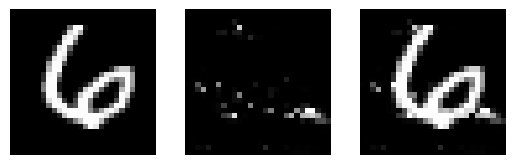

success
7 -> 2


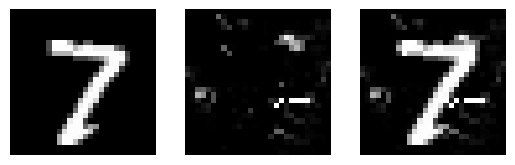

success
9 -> 2


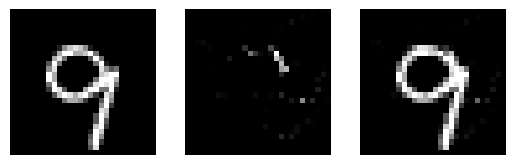

success
0 -> 2


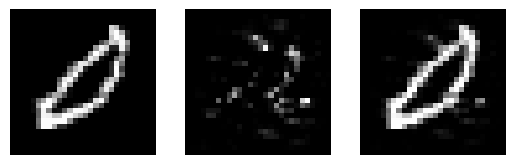

success
6 -> 2


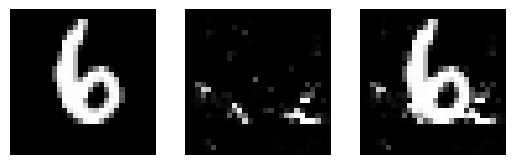

success
8 -> 2
success
7 -> 2
success
9 -> 2
success
0 -> 2
success
7 -> 2
success
4 -> 2
success
3 -> 2
success
9 -> 2
success
6 -> 2
success
0 -> 2
success
4 -> 2
success
3 -> 2
success
8 -> 2
success
7 -> 2
success
7 -> 2
success
6 -> 2
success
3 -> 2
success
1 -> 2
success
3 -> 2
success
5 -> 2
success
4 -> 2
success
5 -> 2
success
4 -> 2
success
0 -> 2
success
1 -> 2
success
9 -> 2
success
9 -> 2
success
0 -> 2
success
0 -> 2
success
7 -> 2
success
0 -> 2
success
5 -> 2
success
3 -> 2
success
0 -> 2
success
8 -> 2
success
4 -> 2
success
7 -> 2
success
9 -> 2
success
9 -> 2
success
9 -> 2
success
0 -> 2
success
8 -> 2
success
4 -> 2
success
3 -> 2
success
9 -> 2
success
1 -> 2
success
6 -> 2
success
7 -> 2
success
9 -> 2
success
1 -> 2
success
3 -> 2
success
4 -> 2
success
0 -> 2
success
8 -> 2
success
7 -> 2
success
3 -> 2
success
9 -> 2
success
3 -> 2
success
1 -> 2
success
3 -> 2
success
4 -> 2
success
8 -> 2
success
4 -> 2
success
9 -> 2
success
9 -> 2
success
8 -> 2
success
7 

In [10]:
# データローダーにあるデータを1つずつ取り出し、すべて用いる。
TARGET_CLASS = 2
MAX_ITER = 200
alpha = 100
model = model.to(device)
j = 0
is_success = 0
for data,target in test_loader:
    j+=1
    
    data= data.to(device)
    orig = data.to(device)
    
    target = target.to(device)
    data.requires_grad = True
    output = model(data)
    
    orig_output = model(orig).max(1,keepdim=True)[1]
    if orig_output == TARGET_CLASS:
        continue
    add = torch.zeros((1,1,28,28)).to(device)
    iter = 0

    while (iter<MAX_ITER) and (output.max(1,keepdim=True)[1] != TARGET_CLASS):
        jacobian = torch.zeros((10,1,28,28))# ヤコビアンを格納する変数
        
        #ヤコビアンの計算
        # 出力のi番目に対する勾配を計算し
        # ヤコビアンのi番目の成分に代入する

        for i in range(10):
            grad=torch.autograd.grad(output[0][i],data,retain_graph=True)
            jacobian[i]=grad[0]

        sat = SAT(jacobian,TARGET_CLASS).to(device)
        add += sat
        
        data = (data + sat).to(device).clamp(0,1)
        
        output = model(data)
        
        iter += 1
        
        if output.max(1,keepdim=True)[1] == TARGET_CLASS or iter == MAX_ITER:
            print("success")
            print(f"{orig_output[0][0]} -> {TARGET_CLASS}")
            is_success += 1
            if (is_success<=5):
                fig, axis = plt.subplots(nrows=1, ncols=3)

                orig_img = orig[0].cpu().detach().numpy()
                axis[0].imshow(orig_img[0],cmap='gray')
                axis[0].axis("off")

                
                add_img = add.cpu().detach().numpy()
                
                # origとdataの差分がノイズとして表示する
                
                add_img = (data-orig).cpu().detach().numpy()
                axis[1].imshow(add_img[0][0],cmap='gray')
                axis[1].axis("off")

                axis[2].imshow(data[0][0].cpu().detach().numpy(),cmap='gray')
                axis[2].axis("off")
                
                plt.show()
                

                break
        
        

        
    if j==100:
        print(is_success/100)
        break